<a href="https://colab.research.google.com/github/ritammajumdar/Movie_Recommendation/blob/main/movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle

In [2]:
movies=pd.read_csv('movie.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
tags=pd.read_csv('tag.csv')
ratings=pd.read_csv('rating.csv')

In [5]:
ratings.shape

(6554351, 4)

In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2.0,3.5,2005-04-02 23:53:47
1,1,29.0,3.5,2005-04-02 23:31:16
2,1,32.0,3.5,2005-04-02 23:33:39
3,1,47.0,3.5,2005-04-02 23:32:07
4,1,50.0,3.5,2005-04-02 23:29:40


In [8]:
movies['genres']=movies['genres'].str.replace('|',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
len(movies.movieId.unique())

27278

In [11]:
len(ratings.movieId.unique())

21368

In [12]:
ratings_new=ratings.groupby('userId').filter(lambda x:len(x)>=55)
movie_list_rating=ratings_new.movieId.unique().tolist()

In [13]:
len(ratings_new.movieId.unique())/len(movies.movieId.unique()) *100

78.04824400615881

In [14]:
len(ratings_new.userId.unique())/len(ratings.userId.unique()) *100

58.19573901464714

In [15]:
movies=movies[movies.movieId.isin(movie_list_rating)]

In [16]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
mapping=dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [18]:
tags.drop(['timestamp'],1,inplace=True)
ratings_new.drop(['timestamp'],1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [19]:
merged_data=pd.merge(movies,tags,on='movieId',how='left')

In [20]:
merged_data.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Pixar animation
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,TÃ©a Leoni does not star in this movie


In [21]:
merged_data.fillna(" ",inplace=True)
merged_data=pd.DataFrame(merged_data.groupby('movieId')['tag'].apply(lambda x:"%s" % ' '.join(x)))
final_data=pd.merge(movies,merged_data,on='movieId',how='left')
final_data['metadata']=final_data[['tag','genres']].apply(lambda x:' '.join(x),axis=1)
final_data[['movieId','title','metadata']].head()

,movieId,title,metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Diane Keaton family sequel Steve Martin weddin...


In [22]:
final_data.shape

(21289, 5)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(final_data['metadata'])
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(),index=final_data.index.tolist())
print(tfidf_df.shape)

(21289, 22968)


Text(0, 0.5, 'cumulative percent of variance')

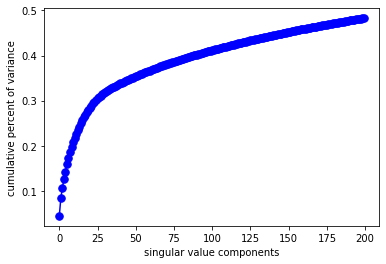

In [24]:
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=200)
latent_matrix=svd.fit_transform(tfidf_df)
explained=svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=15,color='blue')
plt.xlabel('singular value components',fontsize=10)
plt.ylabel('cumulative percent of variance',fontsize=10)

In [25]:
n=100
latent_matrix_df=pd.DataFrame(latent_matrix[:,0:n],index=final_data.title.tolist())

In [26]:
latent_matrix.shape

(21289, 200)

In [27]:
ratings_new.head()

,userId,movieId,rating
0,1,2.0,3.5
1,1,29.0,3.5
2,1,32.0,3.5
3,1,47.0,3.5
4,1,50.0,3.5


In [28]:
ratings_final_1=pd.merge(movies['movieId'],ratings_new,on="movieId",how="right")
ratings_final_1.head()

,movieId,userId,rating
0,2.0,1,3.5
1,29.0,1,3.5
2,32.0,1,3.5
3,47.0,1,3.5
4,50.0,1,3.5
